 # 1. Setup and Data Loading

In [2]:
!pip install fsspec==2023.9.2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 13.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requi

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


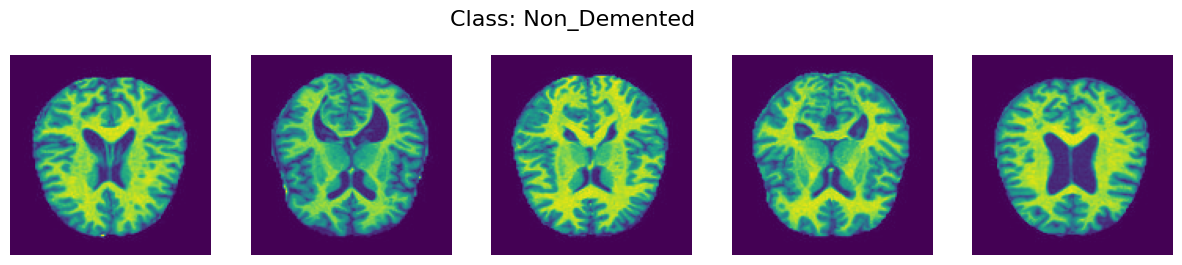

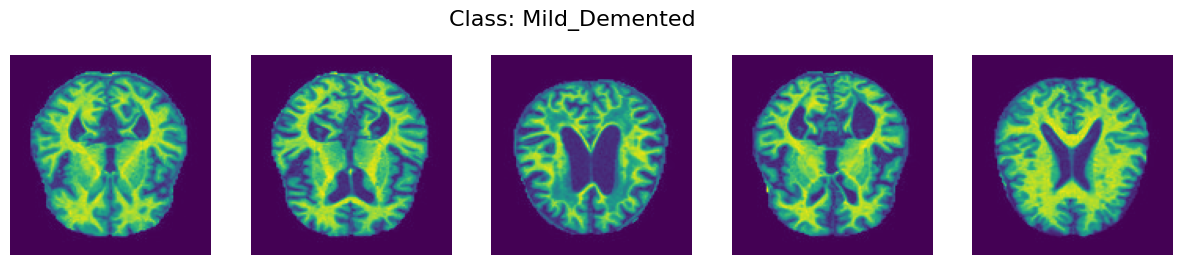

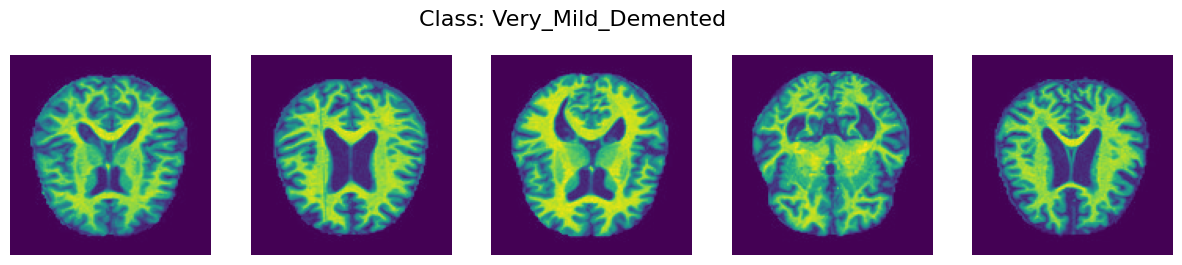

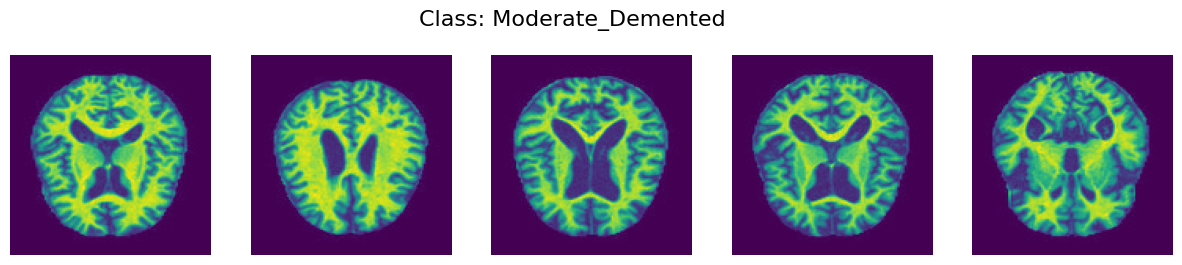

In [1]:
import matplotlib.pyplot as plt
from datasets import load_dataset
from collections import defaultdict

# Load dataset
dataset = load_dataset("Falah/Alzheimer_MRI", split="train")

# Get class label names
label_names = dataset.features["label"].names

# Group images by class (limit to 5 per class)
images_by_class = defaultdict(list)
for example in dataset:
    label = example["label"]
    if len(images_by_class[label]) < 5:
        images_by_class[label].append(example["image"])
    if all(len(images_by_class[i]) == 5 for i in range(len(label_names))):
        break  # Stop once we have 5 images per class

# Plot 5 images per class
for label_idx, images in images_by_class.items():
    class_name = label_names[label_idx]
    plt.figure(figsize=(15, 3))
    plt.suptitle(f"Class: {class_name}", fontsize=16)

    for i, image in enumerate(images):
        plt.subplot(1, 5, i + 1)
        plt.imshow(image)
        plt.axis("off")

    plt.show()


In [2]:
# Install Hugging Face datasets and transformers if not already installed
!pip install -q datasets transformers

# Import required libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from torchvision import models
from datasets import load_dataset

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [3]:
# Load the dataset from Hugging Face
dataset_train = load_dataset('Falah/Alzheimer_MRI', split='train')  # 5120 training images
dataset_test = load_dataset('Falah/Alzheimer_MRI', split='test')    # 1280 test images

print(f"Total training images: {len(dataset_train)}")
print(f"Total test images: {len(dataset_test)}")

# Create a validation split from training data (e.g., 20% for validation)
val_fraction = 0.2
val_size = int(val_fraction * len(dataset_train))
train_size = len(dataset_train) - val_size
dataset_train, dataset_val = random_split(dataset_train, [train_size, val_size], generator=torch.Generator().manual_seed(42))

print(f"Training images after split: {len(dataset_train)}, Validation images: {len(dataset_val)}")


Total training images: 5120
Total test images: 1280
Training images after split: 4096, Validation images: 1024


# 2. Preprocessing and Data Preparation

In [4]:
# Define image transformations for training and validation/test
# The Vision Transformer was pre-trained on ImageNet, so we use ImageNet mean/std for normalization
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),              # resize to 224x224
    transforms.RandomHorizontalFlip(p=0.5),     # random horizontal flip for augmentation
    transforms.RandomRotation(degrees=10),      # small random rotation for augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# For validation and test, use only deterministic transformations (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])


In [9]:
class AlzheimerMRIDataset(Dataset):
    def __init__(self, hf_dataset, transform=None, sequence_length=5):
        self.hf_dataset = hf_dataset  # FIXED: store as instance variable
        self.transform = transform
        self.sequence_length = sequence_length
        self.sequences = []
        self.labels = []

        # Group image indices by class label
        label_to_indices = {0: [], 1: [], 2: [], 3: []}
        for idx, sample in enumerate(hf_dataset):
            label = int(sample['label'])
            label_to_indices[label].append(idx)

        # Form sequences for each label group
        for label, indices in label_to_indices.items():
            np.random.shuffle(indices)
            for i in range(0, len(indices) - sequence_length + 1, sequence_length):
                seq_indices = indices[i:i+sequence_length]
                if len(seq_indices) == sequence_length:
                    self.sequences.append(seq_indices)
                    self.labels.append(label)

        # Shuffle all sequences
        combined = list(zip(self.sequences, self.labels))
        np.random.shuffle(combined)
        self.sequences, self.labels = zip(*combined)
        self.sequences = list(self.sequences)
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq_indices = self.sequences[idx]
        label = int(self.labels[idx])
        images = []
        for img_idx in seq_indices:
            sample = self.hf_dataset[img_idx]  # FIXED: use self.hf_dataset
            img = sample['image']
            if self.transform:
                img = self.transform(img)
            images.append(img)
        seq_tensor = torch.stack(images)
        return seq_tensor, label

# Set sequence length (e.g., 5 slices per sequence)
SEQ_LENGTH = 5

# Create dataset instances for train, val, and test
train_dataset_seq = AlzheimerMRIDataset(dataset_train, transform=train_transform, sequence_length=SEQ_LENGTH)
val_dataset_seq   = AlzheimerMRIDataset(dataset_val, transform=val_transform, sequence_length=SEQ_LENGTH)
test_dataset_seq  = AlzheimerMRIDataset(dataset_test, transform=val_transform, sequence_length=SEQ_LENGTH)

print(f"Number of training sequences: {len(train_dataset_seq)}")
print(f"Number of validation sequences: {len(val_dataset_seq)}")
print(f"Number of test sequences: {len(test_dataset_seq)}")


Number of training sequences: 817
Number of validation sequences: 204
Number of test sequences: 254


In [11]:
from torchvision import transforms

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")),  # ← Convert grayscale to RGB
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

val_transform = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")),  # ← Convert grayscale to RGB
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])


In [12]:
# Create dataset instances again
train_dataset_seq = AlzheimerMRIDataset(dataset_train, transform=train_transform, sequence_length=5)
val_dataset_seq   = AlzheimerMRIDataset(dataset_val, transform=val_transform, sequence_length=5)
test_dataset_seq  = AlzheimerMRIDataset(dataset_test, transform=val_transform, sequence_length=5)

# Loaders
train_loader = DataLoader(train_dataset_seq, batch_size=8, shuffle=True, drop_last=True)
val_loader   = DataLoader(val_dataset_seq, batch_size=8, shuffle=False)
test_loader  = DataLoader(test_dataset_seq, batch_size=8, shuffle=False)

# Check shape
example_batch = next(iter(train_loader))
images_seq, labels_seq = example_batch
print("Batch sequence tensor shape:", images_seq.shape)
print("Batch labels shape:", labels_seq.shape)


Batch sequence tensor shape: torch.Size([8, 5, 3, 224, 224])
Batch labels shape: torch.Size([8])


# 3. Model Architecture: Vision Transformer + Bi-LSTM

In [13]:
# Define the hybrid model combining ViT and Bi-LSTM
class ViT_BiLSTM_Model(nn.Module):
    def __init__(self, hidden_dim=256, num_classes=4):
        super(ViT_BiLSTM_Model, self).__init__()
        # Load pretrained ViT (Base model, 16x16 patches, 224x224, pre-trained on ImageNet)
        self.vit = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
        # Replace ViT's head with identity to get features instead of ImageNet classes
        self.vit.heads = nn.Identity()  # For torchvision ViT model, .heads is the classification head
        vit_feature_dim = 768  # ViT-Base output feature dimension
        # Bi-directional LSTM
        self.lstm = nn.LSTM(input_size=vit_feature_dim, hidden_size=hidden_dim, num_layers=1,
                             batch_first=True, bidirectional=True)
        # Dropout for regularization
        self.dropout = nn.Dropout(p=0.5)
        # Fully connected layer for classification (input = 2*hidden_dim because of Bi-LSTM)
        self.fc = nn.Linear(2 * hidden_dim, num_classes)

    def forward(self, x):
        # x shape: (batch, seq_length, 3, 224, 224)
        batch_size, seq_length, C, H, W = x.size()
        # Merge batch and sequence dimensions to process all images at once through ViT
        x_reshaped = x.view(batch_size * seq_length, C, H, W)
        # Extract features with ViT (for each image in the sequence)
        with torch.no_grad():  # optionally freeze ViT feature extractor
            vit_features = self.vit(x_reshaped)
        # vit_features shape: (batch_size*seq_length, vit_feature_dim)
        # Reshape back to sequence format
        vit_features = vit_features.view(batch_size, seq_length, -1)
        # Pass sequence of features through Bi-LSTM
        lstm_out, (h_n, c_n) = self.lstm(vit_features)  # h_n shape: (num_layers*2, batch, hidden_dim)
        # Concatenate final hidden state from forward and backward LSTM
        # For 1-layer Bi-LSTM: h_n[0] is last hidden of forward direction, h_n[1] is last hidden of backward
        h_forward = h_n[0]  # shape (batch, hidden_dim)
        h_backward = h_n[1]  # shape (batch, hidden_dim)
        h_final = torch.cat((h_forward, h_backward), dim=1)  # shape (batch, 2*hidden_dim)
        # Apply dropout
        h_final = self.dropout(h_final)
        # Classify
        logits = self.fc(h_final)  # shape (batch, num_classes)
        return logits

# Instantiate the model, define loss function and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViT_BiLSTM_Model(hidden_dim=256, num_classes=4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# Learning rate scheduler (e.g., reduce LR by factor of 0.1 every 5 epochs)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 232MB/s]


# 4. Training Loop with Early Stopping and Validation

In [15]:
# Training parameters
num_epochs = 20
patience = 3  # early stopping patience

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images_seq, labels in train_loader:
        images_seq = images_seq.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images_seq)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # Validation
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images_seq, labels in val_loader:
            images_seq = images_seq.to(device)
            labels = labels.to(device)

            outputs = model(images_seq)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    scheduler.step()

    print(f"Epoch {epoch:02d} | Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} "
          f"| Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # Early stopping check
    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break


Epoch 01 | Train Loss: 0.9867, Acc: 0.5429 | Val Loss: 0.8362, Acc: 0.6471
Epoch 02 | Train Loss: 0.7643, Acc: 0.6507 | Val Loss: 0.7908, Acc: 0.6863
Epoch 03 | Train Loss: 0.6258, Acc: 0.7426 | Val Loss: 0.6902, Acc: 0.7255
Epoch 04 | Train Loss: 0.5567, Acc: 0.7672 | Val Loss: 0.6059, Acc: 0.7451
Epoch 05 | Train Loss: 0.5007, Acc: 0.7953 | Val Loss: 0.5659, Acc: 0.7402
Epoch 06 | Train Loss: 0.4580, Acc: 0.8260 | Val Loss: 0.5694, Acc: 0.7745
Epoch 07 | Train Loss: 0.4496, Acc: 0.8186 | Val Loss: 0.5694, Acc: 0.7598
Epoch 08 | Train Loss: 0.4239, Acc: 0.8395 | Val Loss: 0.5502, Acc: 0.7794
Epoch 09 | Train Loss: 0.4369, Acc: 0.8284 | Val Loss: 0.5736, Acc: 0.7843
Epoch 10 | Train Loss: 0.4178, Acc: 0.8358 | Val Loss: 0.5474, Acc: 0.7647
Epoch 11 | Train Loss: 0.4251, Acc: 0.8333 | Val Loss: 0.5473, Acc: 0.7647
Epoch 12 | Train Loss: 0.4124, Acc: 0.8444 | Val Loss: 0.5454, Acc: 0.7696
Epoch 13 | Train Loss: 0.4121, Acc: 0.8493 | Val Loss: 0.5443, Acc: 0.7696
Epoch 14 | Train Loss: 0.

# 5. Evaluation on Test Set

In [16]:
# Load the best model weights (from early stopping) before evaluating on test
model.load_state_dict(torch.load("best_model.pth"))

model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images_seq, labels in test_loader:
        images_seq = images_seq.to(device)
        labels = labels.to(device)
        outputs = model(images_seq)
        _, predicted = torch.max(outputs, 1)
        # collect results
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
test_acc = (all_preds == all_labels).mean()
print(f"Test Accuracy: {test_acc:.4f}")


Test Accuracy: 0.7362


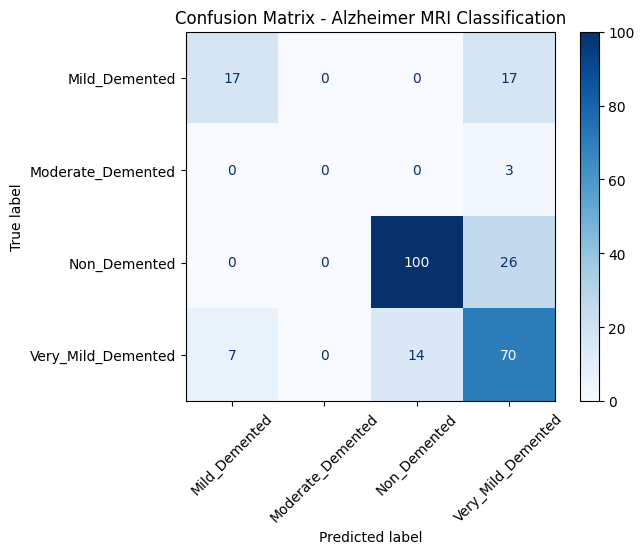

In [17]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=[0,1,2,3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Mild_Demented", "Moderate_Demented", "Non_Demented", "Very_Mild_Demented"])
# Plot the confusion matrix
disp.plot(include_values=True, cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix - Alzheimer MRI Classification")
plt.show()


# 6. Visualizing Training Progress

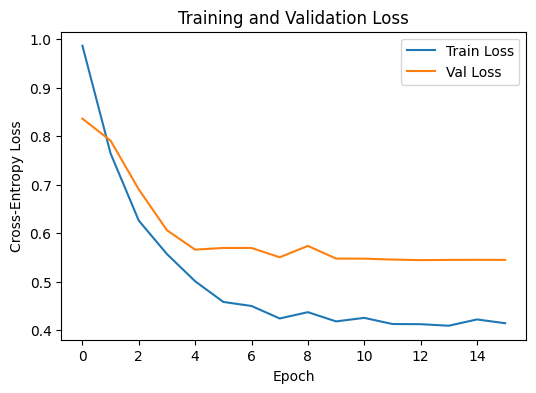

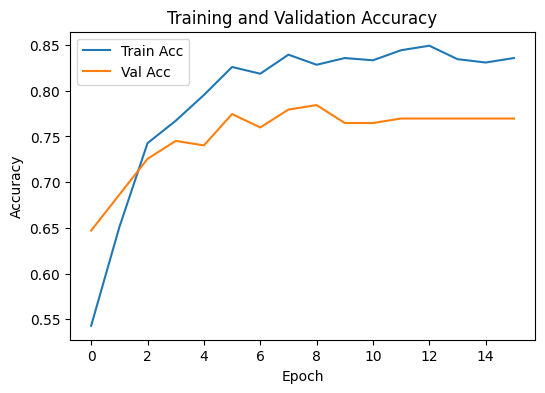

In [18]:
# Plot training & validation loss curve
plt.figure(figsize=(6,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Plot training & validation accuracy curve
plt.figure(figsize=(6,4))
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()


# Display 20 Images from Test Set with Predicted Labels

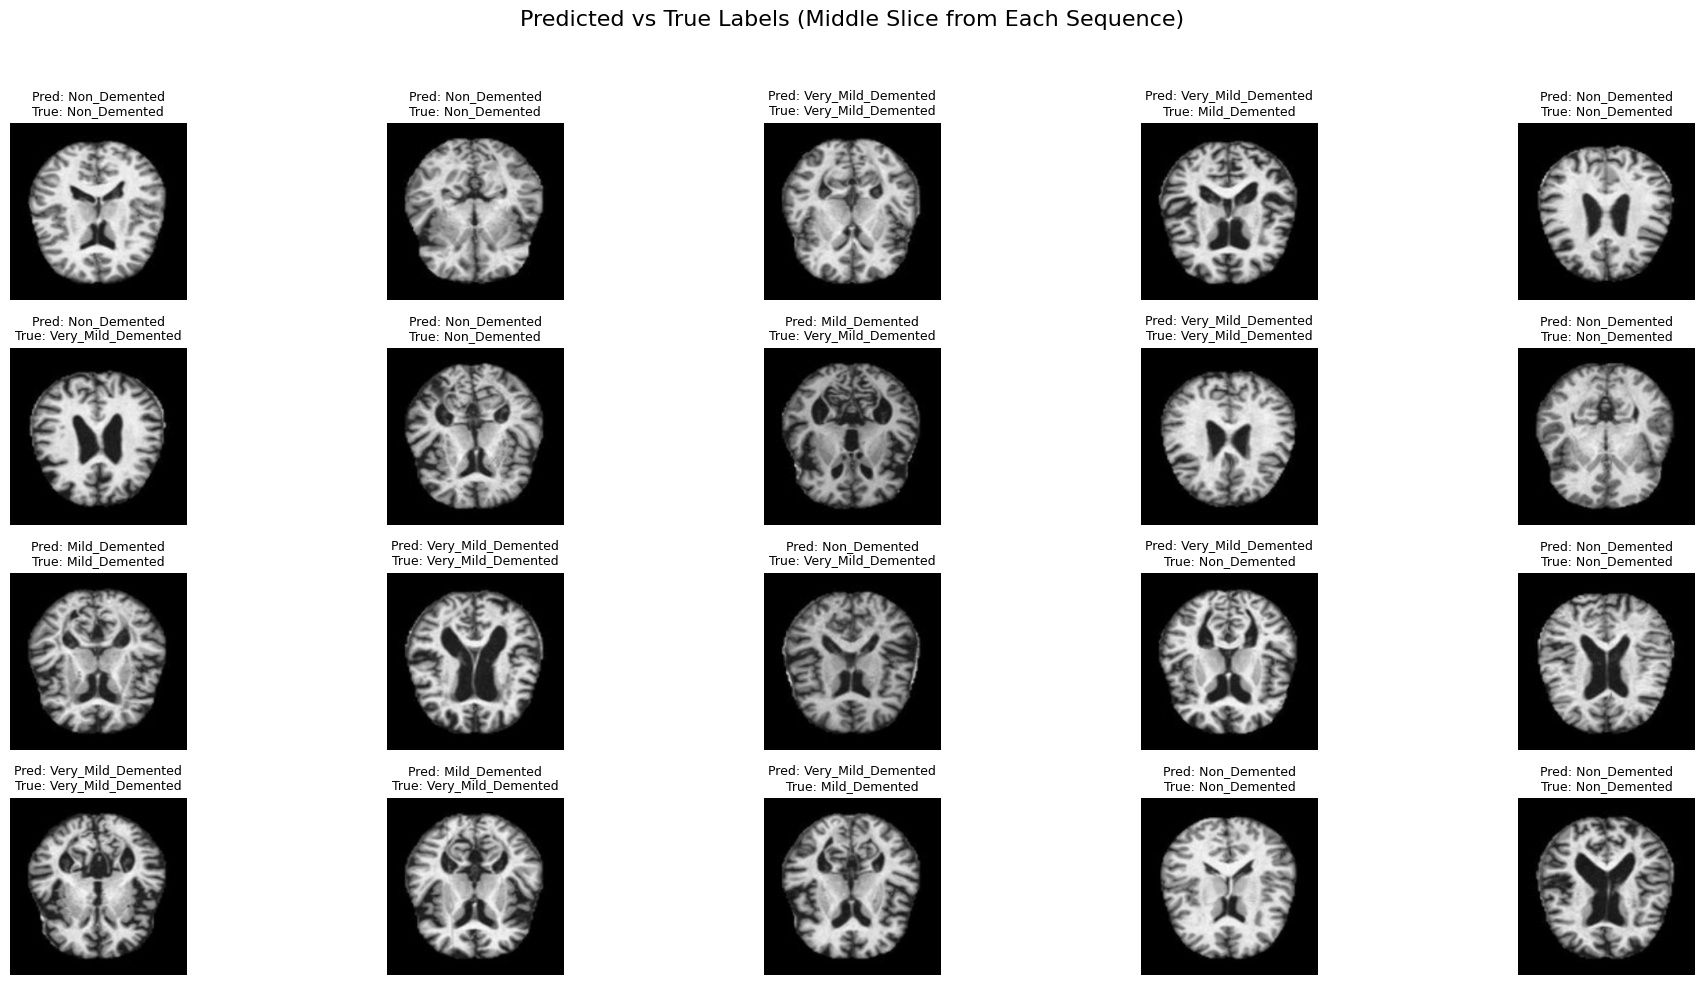

In [19]:
import random
import matplotlib.pyplot as plt

# Load the best model weights
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

# Class label mapping (from dataset)
class_names = {
    0: "Mild_Demented",
    1: "Moderate_Demented",
    2: "Non_Demented",
    3: "Very_Mild_Demented"
}

# Select 20 random indices from test dataset
num_images = 20
indices = random.sample(range(len(test_dataset_seq)), num_images)

# Plot results
plt.figure(figsize=(20, 10))

for i, idx in enumerate(indices):
    # Get sequence and label
    image_seq, true_label = test_dataset_seq[idx]
    image_seq = image_seq.unsqueeze(0).to(device)  # add batch dimension
    with torch.no_grad():
        output = model(image_seq)
        predicted_label = torch.argmax(output, dim=1).item()

    # Take the middle slice in the sequence to display
    middle_slice = image_seq[0, len(image_seq[0]) // 2].cpu()
    # Unnormalize for visualization
    img = middle_slice.permute(1, 2, 0).numpy()  # shape: (224, 224, 3)
    img = img * np.array(IMAGENET_STD) + np.array(IMAGENET_MEAN)
    img = np.clip(img, 0, 1)

    # Plot image
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Pred: {class_names[predicted_label]}\nTrue: {class_names[true_label]}", fontsize=9)

plt.suptitle("Predicted vs True Labels (Middle Slice from Each Sequence)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# Improved ViT + Bi-LSTM Training Pipeline for Alzheimer's MRI Classification

**Data Preparation and Augmentation**

In [23]:
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import torch

# Load datasets from Hugging Face
dataset_train = load_dataset('Falah/Alzheimer_MRI', split='train')
dataset_test  = load_dataset('Falah/Alzheimer_MRI', split='test')

# Define transforms (including conversion to RGB)
IMG_SIZE = 224
train_transforms = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

val_transforms = transforms.Compose([
    transforms.Lambda(lambda x: x.convert("RGB")),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Custom Dataset using Hugging Face dataset object
from collections import Counter

class HuggingfaceAlzheimerDataset(Dataset):
    def __init__(self, hf_dataset, transform=None, sequence_length=32):
        self.hf_dataset = hf_dataset
        self.transform = transform
        self.sequence_length = sequence_length
        self.samples = []

        total = len(hf_dataset)
        for i in range(0, total - sequence_length + 1, sequence_length):
            seq_indices = list(range(i, i + sequence_length))
            labels = [hf_dataset[j]['label'] for j in seq_indices]
            most_common_label = Counter(labels).most_common(1)[0][0]  # get majority label
            self.samples.append((seq_indices, most_common_label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        seq_indices, label = self.samples[idx]
        images = []
        for j in seq_indices:
            img = self.hf_dataset[j]['image']
            if self.transform:
                img = self.transform(img)
            images.append(img)
        seq_tensor = torch.stack(images)
        return seq_tensor, label



train_dataset = HuggingfaceAlzheimerDataset(dataset_train, transform=train_transforms)
val_dataset   = HuggingfaceAlzheimerDataset(dataset_train, transform=val_transforms)
test_dataset  = HuggingfaceAlzheimerDataset(dataset_test,  transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)



**Model Architecture**
**Vision Transformer + Bi-LSTM Model**

In [24]:
import torch.nn as nn
import torchvision.models as models
# Alternatively, one can use timm: `pip install timm` and then:
# import timm
# vit_backbone = timm.create_model('vit_base_patch16_224', pretrained=True)
# vit_backbone.head = nn.Identity()  # remove default classifier

class ViT_BiLSTM_Model(nn.Module):
    def __init__(self, num_classes=4, hidden_size=128, num_lstm_layers=1, dropout=0.2):
        super(ViT_BiLSTM_Model, self).__init__()
        # Load a pretrained Vision Transformer (ViT-B/16) from torchvision
        vit_weights = models.ViT_B_16_Weights.DEFAULT  # ImageNet pre-trained weights
        self.vit = models.vit_b_16(weights=vit_weights)
        # Replace ViT's classification head with identity to get raw features
        # Torchvision ViT has model.heads, which is a Sequential containing the final Linear
        self.vit.heads.head = nn.Identity()  # now vit(x) will output a 768-dim embedding (CLS token)

        # Freeze or unfreeze: here we fine-tune, so we leave all parameters trainable.
        # (If we wanted to freeze some layers to save memory, we could do:
        # for param in self.vit.parameters(): param.requires_grad = False
        # and then unfreeze last few layers. But we aim to fine-tune entire ViT.)

        # Bi-LSTM to process sequence of embeddings
        self.hidden_size = hidden_size
        self.num_layers = num_lstm_layers
        self.bidirectional = True
        num_directions = 2 if self.bidirectional else 1
        self.lstm = nn.LSTM(input_size=768, hidden_size=hidden_size, num_layers=num_lstm_layers,
                             batch_first=True, bidirectional=self.bidirectional, dropout=dropout if num_lstm_layers > 1 else 0)
        # Define a dropout layer (for outputs of LSTM or fully connected)
        self.dropout = nn.Dropout(dropout)
        # Classification layer
        fc_input_dim = hidden_size * num_directions  # 2*hidden if bidirectional
        self.fc = nn.Linear(fc_input_dim, num_classes)

    def forward(self, x):
        # x shape: (batch, seq_len, C, H, W)
        batch_size, seq_len, C, H, W = x.size()
        # Merge batch and seq dimensions to process all slices through ViT at once
        x = x.view(batch_size * seq_len, C, H, W)  # shape: (batch*seq_len, C, H, W)
        # Extract features with ViT (forward pass through transformer encoder)
        feats = self.vit(x)  # shape: (batch*seq_len, 768)
        # Restore batch and sequence structure
        feats = feats.view(batch_size, seq_len, -1)  # shape: (batch, seq_len, 768)

        # Pass sequence of feature vectors through Bi-LSTM
        # h0, c0 default to zero if not provided. LSTM outputs:
        # out: (batch, seq_len, hidden_size * num_directions)
        # h_n: (num_layers * num_directions, batch, hidden_size) -> final hidden states
        out, (h_n, c_n) = self.lstm(feats)

        # For bidirectional LSTM, concatenate the final forward and backward hidden states from the last layer
        if self.bidirectional:
            # h_n shape = (2*num_layers, batch, hidden_size). We want the last layer's two hidden states
            # Index -2 for forward last layer, -1 for backward last layer
            h_forward = h_n[-2]  # shape: (batch, hidden_size)
            h_backward = h_n[-1] # shape: (batch, hidden_size)
            h_final = torch.cat([h_forward, h_backward], dim=1)  # shape: (batch, 2*hidden_size)
        else:
            h_final = h_n[-1]    # shape: (batch, hidden_size)

        # Optional: one could also use the last output vector 'out[:,-1,:]' which for a bi-LSTM would be similar to h_final.
        # Apply dropout to the combined hidden representation
        h_final = self.dropout(h_final)
        # Final classification
        logits = self.fc(h_final)  # shape: (batch, num_classes)
        return logits

# Initialize the model
model_vit_lstm = ViT_BiLSTM_Model(num_classes=4, hidden_size=128, num_lstm_layers=2, dropout=0.3)
print(model_vit_lstm)


ViT_BiLSTM_Model(
  (vit): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1): 

**CNN + Bi-LSTM Model (Alternative)**

In [25]:
class CNN_BiLSTM_Model(nn.Module):
    def __init__(self, num_classes=4, hidden_size=128, num_lstm_layers=1, dropout=0.2):
        super(CNN_BiLSTM_Model, self).__init__()
        # Load a pretrained CNN (ResNet18) and remove its final classification layer
        cnn_weights = models.ResNet18_Weights.DEFAULT
        self.cnn = models.resnet18(weights=cnn_weights)
        self.cnn.fc = nn.Identity()  # last fully connected layer removed -> output is 512-dim (ResNet18 final avgpool embedding)
        # (For ResNet50, it would be 2048-dim output, with higher accuracy but more memory usage)

        # Bi-LSTM for sequence modeling (similar to above)
        self.hidden_size = hidden_size
        self.num_layers = num_lstm_layers
        self.bidirectional = True
        num_directions = 2 if self.bidirectional else 1
        self.lstm = nn.LSTM(input_size=512, hidden_size=hidden_size, num_layers=num_lstm_layers,
                             batch_first=True, bidirectional=self.bidirectional, dropout=dropout if num_lstm_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size * num_directions, num_classes)

    def forward(self, x):
        # x: (batch, seq_len, C, H, W)
        batch_size, seq_len, C, H, W = x.size()
        # Flatten batch and seq to process all slices through CNN
        x_flat = x.view(batch_size * seq_len, C, H, W)
        feats = self.cnn(x_flat)           # shape: (batch*seq_len, 512)
        feats = feats.view(batch_size, seq_len, -1)  # (batch, seq_len, 512)

        out, (h_n, c_n) = self.lstm(feats)
        if self.bidirectional:
            h_forward = h_n[-2]
            h_backward = h_n[-1]
            h_final = torch.cat([h_forward, h_backward], dim=1)
        else:
            h_final = h_n[-1]
        h_final = self.dropout(h_final)
        logits = self.fc(h_final)
        return logits

# Initialize the CNN+LSTM model
model_cnn_lstm = CNN_BiLSTM_Model(num_classes=4, hidden_size=128, num_lstm_layers=2, dropout=0.3)
print(model_cnn_lstm)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 193MB/s]

CNN_BiLSTM_Model(
  (cnn): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

# Training Configuration and Hyperparameters

In [26]:
import torch
import torch.optim as optim

# Select device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
model = model_vit_lstm.to(device)  # train the ViT+LSTM model; for CNN model, use model_cnn_lstm

# Define optimizer (AdamW is often used for ViT, here we use AdamW with weight decay)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Optionally, set up a learning rate scheduler (for example, cosine decay or ReduceLROnPlateau)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

# Loss function
criterion = nn.CrossEntropyLoss()

# Mixed precision scaler
scaler = torch.cuda.amp.GradScaler()


Using device: cuda


<ipython-input-26-eab5c2c587d4>:19: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


**Training and Validation Loop**

In [28]:
import numpy as np

num_epochs = 20
best_val_acc = 0.0

for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for sequences, labels in train_loader:
        sequences = sequences.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
            outputs = model(sequences)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * sequences.size(0)
        _, predicted = torch.max(outputs, dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for sequences, labels in val_loader:
            sequences = sequences.to(device)
            labels = labels.to(device)
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                outputs = model(sequences)
                loss = criterion(outputs, labels)
            val_loss += loss.item() * sequences.size(0)
            _, predicted = torch.max(outputs, dim=1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= total_val
    val_acc = correct_val / total_val

    print(f"Epoch {epoch}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print(f"✅ Saved new best model (Val Acc: {best_val_acc:.4f})")


<ipython-input-28-7d048cf77970>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
<ipython-input-28-7d048cf77970>:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):


Epoch 1/20 | Train Loss: 0.7146, Acc: 0.7812 | Val Loss: 0.5501, Acc: 0.8000
✅ Saved new best model (Val Acc: 0.8000)
Epoch 2/20 | Train Loss: 0.5507, Acc: 0.8000 | Val Loss: 0.5241, Acc: 0.8000
Epoch 3/20 | Train Loss: 0.5251, Acc: 0.8000 | Val Loss: 0.5211, Acc: 0.8000
Epoch 4/20 | Train Loss: 0.5196, Acc: 0.8000 | Val Loss: 0.5150, Acc: 0.8000
Epoch 5/20 | Train Loss: 0.5247, Acc: 0.8000 | Val Loss: 0.5074, Acc: 0.8000
Epoch 6/20 | Train Loss: 0.5225, Acc: 0.8000 | Val Loss: 0.5067, Acc: 0.8000
Epoch 7/20 | Train Loss: 0.5024, Acc: 0.8000 | Val Loss: 0.5044, Acc: 0.8000
Epoch 8/20 | Train Loss: 0.5133, Acc: 0.8000 | Val Loss: 0.5083, Acc: 0.8000
Epoch 9/20 | Train Loss: 0.5096, Acc: 0.8000 | Val Loss: 0.5048, Acc: 0.8000
Epoch 10/20 | Train Loss: 0.5243, Acc: 0.8000 | Val Loss: 0.5095, Acc: 0.8000
Epoch 11/20 | Train Loss: 0.5387, Acc: 0.8000 | Val Loss: 0.5044, Acc: 0.8000
Epoch 12/20 | Train Loss: 0.5115, Acc: 0.8000 | Val Loss: 0.5059, Acc: 0.8000
Epoch 13/20 | Train Loss: 0.5358

**Evaluation on Test Set**

Test Accuracy: 0.8250
Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented       0.00      0.00      0.00         1
 Moderate_Demented       0.00      0.00      0.00         0
      Non_Demented       0.82      1.00      0.90        33
Very_Mild_Demented       0.00      0.00      0.00         6

          accuracy                           0.82        40
         macro avg       0.21      0.25      0.23        40
      weighted avg       0.68      0.82      0.75        40



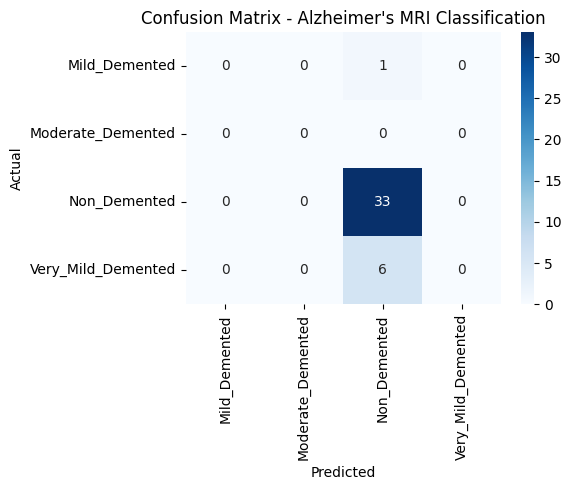

In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define label order
labels = [0, 1, 2, 3]
target_names = ["Mild_Demented", "Moderate_Demented", "Non_Demented", "Very_Mild_Demented"]

# Accuracy
test_accuracy = np.mean(np.array(y_true) == np.array(y_pred))
print(f"Test Accuracy: {test_accuracy:.4f}")


# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, labels=labels, target_names=target_names, zero_division=0))

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Alzheimer's MRI Classification")
plt.tight_layout()
plt.show()


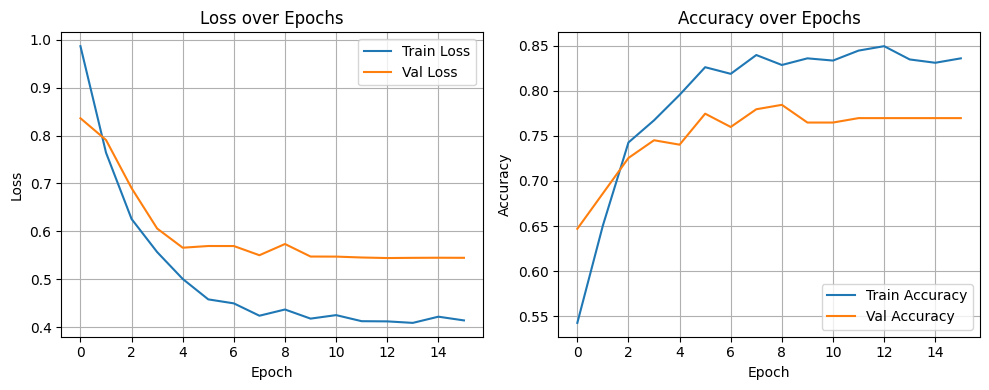

In [32]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


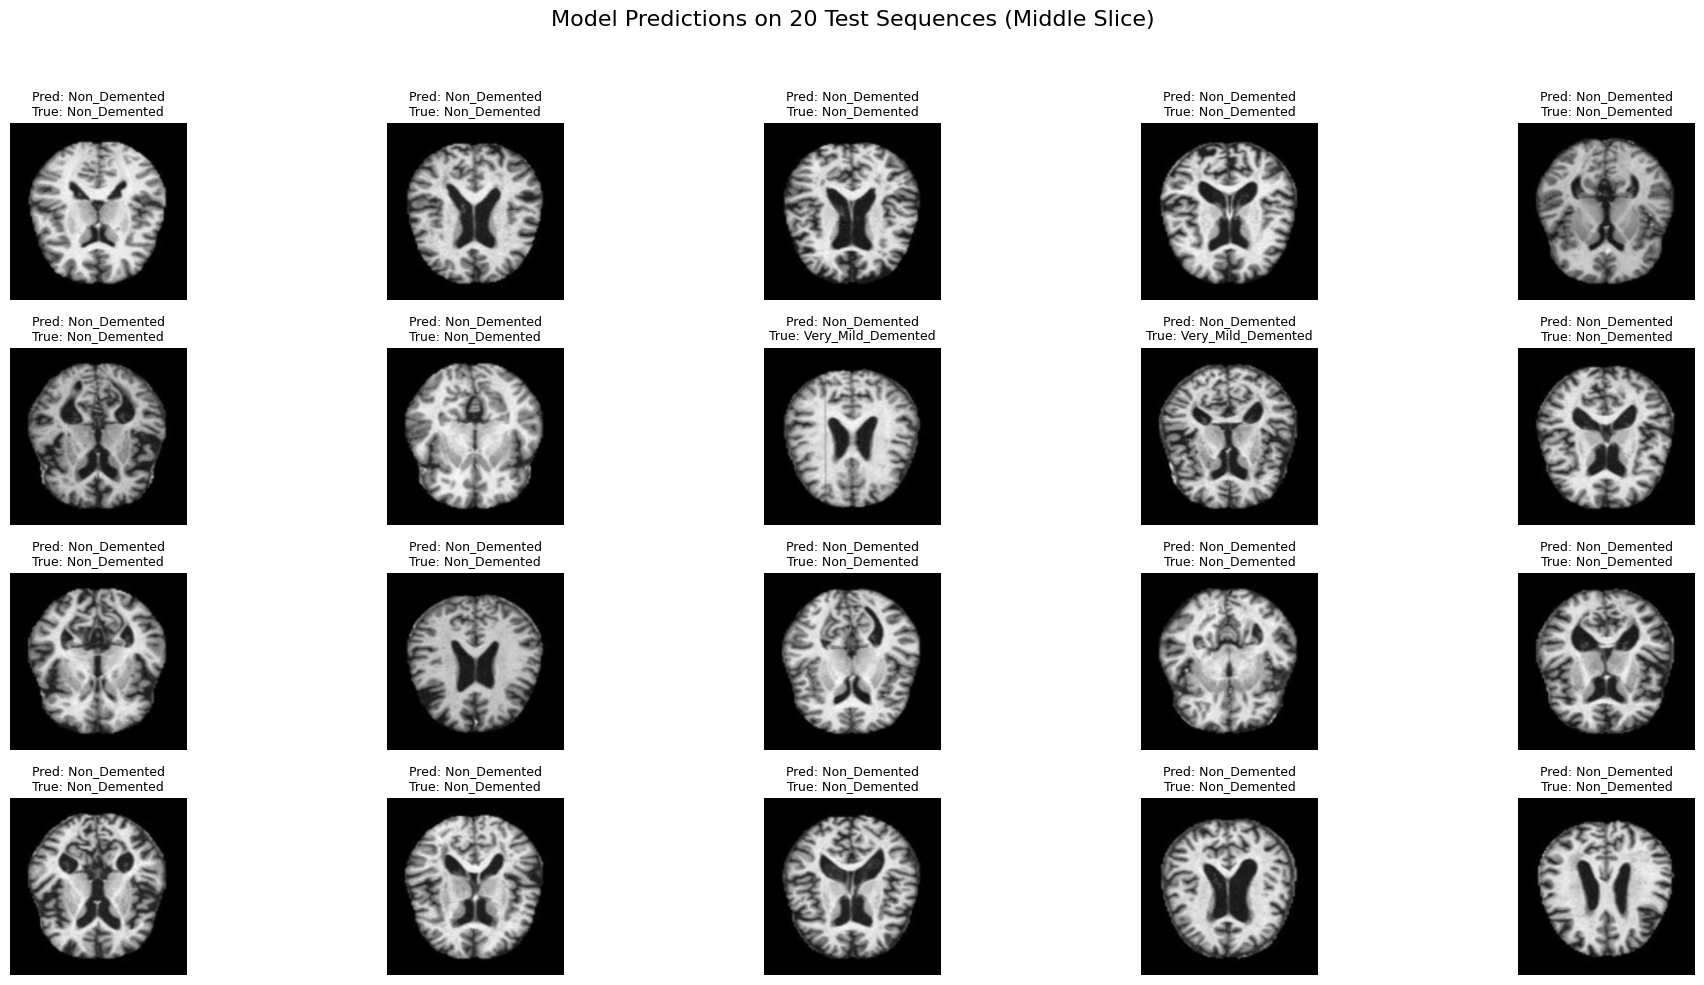

In [33]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Load best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

# Class label names
class_names = ["Mild_Demented", "Moderate_Demented", "Non_Demented", "Very_Mild_Demented"]

# Pick 20 random test samples
indices = random.sample(range(len(test_dataset)), 20)

plt.figure(figsize=(20, 10))

for i, idx in enumerate(indices):
    sequence, true_label = test_dataset[idx]
    sequence = sequence.unsqueeze(0).to(device)  # shape: (1, seq_len, 3, H, W)

    with torch.no_grad():
        output = model(sequence)
        predicted_label = torch.argmax(output, dim=1).item()

    # Get middle slice for visualization
    mid_slice = sequence[0, sequence.shape[1] // 2].cpu()
    img = mid_slice.permute(1, 2, 0).numpy()
    img = img * 0.5 + 0.5  # unnormalize if mean=std=0.5
    img = np.clip(img, 0, 1)

    plt.subplot(4, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Pred: {class_names[predicted_label]}\nTrue: {class_names[true_label]}", fontsize=9)
    plt.axis("off")

plt.suptitle("Model Predictions on 20 Test Sequences (Middle Slice)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# ViT + Bi-LSTM Pipeline for 3D MRI Classification on ADNI Dataset

# ADNI Dataset

In [35]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [36]:
import os

# Path to your ADNI folder in Drive
adni_folder = "/content/drive/MyDrive/ADNI"

# List all files in the folder
files = os.listdir(adni_folder)
print("Files in ADNI folder:")
for f in files:
    print(f)


Files in ADNI folder:
027_S_1385
130_S_0969
136_S_0579
136_S_0086
116_S_0649
027_S_1082
027_S_1387
051_S_1123
116_S_0382
067_S_0290
023_S_1046
018_S_0335
027_S_0835
023_S_0058
018_S_0450
023_S_1190
023_S_0963
027_S_0403
023_S_1247
005_S_0814
002_S_1018
002_S_1280
002_S_1268
005_S_0448


In [38]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the root ADNI folder
adni_root = '/content/drive/MyDrive/ADNI'

# Store found MRI files
nii_files = []

# Walk through all folders recursively
for root, dirs, files in os.walk(adni_root):
    for file in files:
        if file.endswith('.nii') or file.endswith('.nii.gz'):
            full_path = os.path.join(root, file)
            nii_files.append(full_path)

# Display results
print(f"Found {len(nii_files)} NIfTI files:")
for f in nii_files:
    print(f)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 31 NIfTI files:
/content/drive/MyDrive/ADNI/027_S_1385/MPR__GradWarp__B1_Correction__N3__Scaled/2009-03-12_11_29_27.0/I143178/ADNI_027_S_1385_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20090505102357735_S64402_I143178.nii
/content/drive/MyDrive/ADNI/130_S_0969/MPR____N3__Scaled/2008-11-19_08_55_47.0/I132451/ADNI_130_S_0969_MR_MPR____N3__Scaled_Br_20081230155100896_S60744_I132451.nii
/content/drive/MyDrive/ADNI/136_S_0579/MPR____N3__Scaled/2008-08-18_11_18_37.0/I120618/ADNI_136_S_0579_MR_MPR____N3__Scaled_Br_20081014114857145_S55502_I120618.nii
/content/drive/MyDrive/ADNI/136_S_0086/MPR____N3__Scaled/2007-05-01_13_01_27.0/I67781/ADNI_136_S_0086_MR_MPR____N3__Scaled_Br_20070815111150885_S31407_I67781.nii
/content/drive/MyDrive/ADNI/136_S_0086/MPR____N3__Scaled/2006-05-08_10_55_23.0/I40172/ADNI_136_S_0086_MR_MPR____N3__Scaled_Br_20070215172221943_S1406

MRI shape: (240, 256, 160)


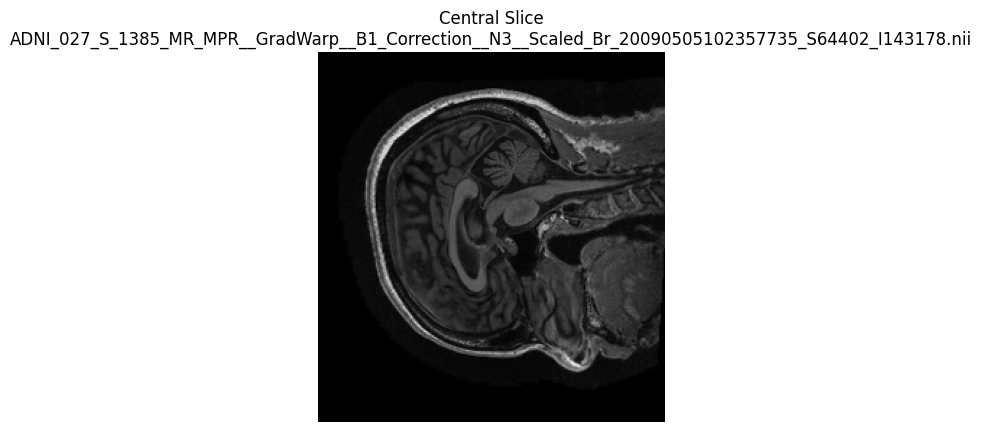

In [39]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

# Load the first MRI file
nii_path = nii_files[0]  # or change index
img = nib.load(nii_path)
data = img.get_fdata()

print("MRI shape:", data.shape)

# Show the central axial slice
plt.imshow(np.rot90(data[:, :, data.shape[2] // 2]), cmap='gray')
plt.title(f"Central Slice\n{os.path.basename(nii_path)}")
plt.axis("off")
plt.show()


In [40]:
!pip install nibabel transformers


In [41]:
import os, glob
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Use GPU if available for faster training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Mount Google Drive (for Colab)
from google.colab import drive
drive.mount('/content/drive')


Using device: cuda
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
# Define the root ADNI folder
adni_root = '/content/drive/MyDrive/ADNI'

# Store found MRI files
nii_files = []

# Walk through all folders recursively
for root, dirs, files in os.walk(adni_root):
    for file in files:
        if file.endswith('.nii') or file.endswith('.nii.gz'):
            full_path = os.path.join(root, file)
            nii_files.append(full_path)

# Display results
print(f"Found {len(nii_files)} NIfTI files:")
for f in nii_files:
    print(f)

Found 31 NIfTI files:
/content/drive/MyDrive/ADNI/027_S_1385/MPR__GradWarp__B1_Correction__N3__Scaled/2009-03-12_11_29_27.0/I143178/ADNI_027_S_1385_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20090505102357735_S64402_I143178.nii
/content/drive/MyDrive/ADNI/130_S_0969/MPR____N3__Scaled/2008-11-19_08_55_47.0/I132451/ADNI_130_S_0969_MR_MPR____N3__Scaled_Br_20081230155100896_S60744_I132451.nii
/content/drive/MyDrive/ADNI/136_S_0579/MPR____N3__Scaled/2008-08-18_11_18_37.0/I120618/ADNI_136_S_0579_MR_MPR____N3__Scaled_Br_20081014114857145_S55502_I120618.nii
/content/drive/MyDrive/ADNI/136_S_0086/MPR____N3__Scaled/2007-05-01_13_01_27.0/I67781/ADNI_136_S_0086_MR_MPR____N3__Scaled_Br_20070815111150885_S31407_I67781.nii
/content/drive/MyDrive/ADNI/136_S_0086/MPR____N3__Scaled/2006-05-08_10_55_23.0/I40172/ADNI_136_S_0086_MR_MPR____N3__Scaled_Br_20070215172221943_S14069_I40172.nii
/content/drive/MyDrive/ADNI/116_S_0649/MPR__GradWarp__B1_Correction__N3__Scaled/2007-08-08_14_06_50.0/I83512/ADNI_11

**Data Preprocessing: Slicing and Normalization**

In [44]:
# Prepare lists to hold data and labels
all_sequences = []
all_labels = []

# Define a transform to convert image to tensor and normalize to mean=0.5, std=0.5
transform = transforms.Compose([
    transforms.ToTensor(),  # converts PIL image [0,255] to float tensor [0,1]
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

for idx, file_path in enumerate(nii_files):
    # Determine pseudo-label for this subject (e.g., 0 for first half, 1 for second half)
    label = 0 if idx < len(nii_files) / 2 else 1

    # Load the 3D MRI volume
    img = nib.load(file_path)
    volume = img.get_fdata().astype(np.float32)  # shape: (X, Y, Z)
    D = volume.shape[2]  # number of axial slices along the third dimension

    # Define central 32-slice range
    if D >= 32:
        start_idx = (D - 32) // 2
        end_idx = start_idx + 32
    else:
        # If volume has <32 slices (unlikely for MRI), pad by repeating edge slices
        start_idx = 0
        end_idx = D
    slices = []
    for s in range(start_idx, end_idx):
        # If out of range (for small volumes), repeat last slice
        if s >= D:
            s = D - 1
        slice2d = volume[:, :, s]             # extract 2D slice
        # Intensity normalization to 0-1
        slice2d = slice2d - slice2d.min()
        if slice2d.max() > 0:
            slice2d = slice2d / slice2d.max()
        else:
            # edge case: flat image (unlikely in brain MRI)
            slice2d = slice2d

        # Convert to 8-bit and to PIL image
        slice_img = Image.fromarray((slice2d * 255).astype(np.uint8), mode='L')
        # Convert grayscale to RGB
        slice_img = slice_img.convert("RGB")
        # Resize to 224x224
        slice_img = slice_img.resize((224, 224), resample=Image.BILINEAR)
        # Apply tensor conversion and normalization
        slice_tensor = transform(slice_img)  # shape: [3, 224, 224]
        slices.append(slice_tensor)

    # Stack slices to shape [32, 3, 224, 224] and add to list
    sequence_tensor = torch.stack(slices)  # one subject's data
    all_sequences.append(sequence_tensor)
    all_labels.append(label)

# Stack all data into one tensor for convenience
X = torch.stack(all_sequences)  # shape: [N_subjects, 32, 3, 224, 224]
y = torch.tensor(all_labels, dtype=torch.long)
print("Data tensor shape:", X.shape, " Labels shape:", y.shape)
print("Label counts:", torch.bincount(y).tolist())


Data tensor shape: torch.Size([31, 32, 3, 224, 224])  Labels shape: torch.Size([31])
Label counts: [16, 15]


**Train-Validation-Test Split**

In [45]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Indices for class 0 and class 1
class0_idx = [i for i, lbl in enumerate(all_labels) if lbl == 0]
class1_idx = [i for i, lbl in enumerate(all_labels) if lbl == 1]
np.random.shuffle(class0_idx)
np.random.shuffle(class1_idx)

# Determine split sizes
n0, n1 = len(class0_idx), len(class1_idx)
train0 = int(0.70 * n0); train1 = int(0.70 * n1)
val0   = int(0.15 * n0); val1   = int(0.15 * n1)
# Ensure at least 1 sample of each class in val/test (adjust if rounding gives 0)
val0 = max(val0, 1); val1 = max(val1, 1)
# Allocate remaining to test
test0 = n0 - train0 - val0
test1 = n1 - train1 - val1

# Split indices for each class
train_indices = class0_idx[:train0] + class1_idx[:train1]
val_indices   = class0_idx[train0:train0+val0] + class1_idx[train1:train1+val1]
test_indices  = class0_idx[train0+val0:] + class1_idx[train1+val1:]
# Shuffle each split's indices (mix class order)
np.random.shuffle(train_indices)
np.random.shuffle(val_indices)
np.random.shuffle(test_indices)

print(f"Train subjects: {len(train_indices)}, Val subjects: {len(val_indices)}, Test subjects: {len(test_indices)}")

# Create TensorDataset and DataLoaders
train_dataset = TensorDataset(X[train_indices], y[train_indices])
val_dataset   = TensorDataset(X[val_indices], y[val_indices])
test_dataset  = TensorDataset(X[test_indices], y[test_indices])

# DataLoader with batch size (subject-level batching)
batch_size = 2  # number of subjects per batch (tune based on GPU memory)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)  # test one subject at a time


Train subjects: 21, Val subjects: 4, Test subjects: 6


**Model Definition: Vision Transformer + Bi-LSTM**

In [46]:
!pip install transformers   # ensure the Hugging Face transformers library is installed


In [47]:
from transformers import ViTModel

class ViT_BiLSTM_Model(nn.Module):
    def __init__(self, num_classes=2, lstm_hidden=128):
        super(ViT_BiLSTM_Model, self).__init__()
        # Load pre-trained ViT model (base patch16, ImageNet-21k)
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        # Freeze ViT parameters to save computation and avoid overfitting
        for param in self.vit.parameters():
            param.requires_grad = False
        vit_hidden_dim = self.vit.config.hidden_size  # typically 768 for ViT-Base
        # Define a Bi-LSTM to process the sequence of slice features
        self.lstm = nn.LSTM(input_size=vit_hidden_dim, hidden_size=lstm_hidden,
                             num_layers=1, batch_first=True, bidirectional=True)
        # Classification layer: input 2*lstm_hidden (forward+backward) -> output classes
        self.classifier = nn.Linear(2 * lstm_hidden, num_classes)

    def forward(self, x):
        # x shape: [B, 32, 3, 224, 224]
        B, T, C, H, W = x.shape
        # Merge batch and time dims to process all slices at once through ViT
        x_flat = x.view(B * T, C, H, W)
        # ViT forward pass (no grad if frozen) to get sequence of embeddings
        vit_outputs = self.vit(x_flat)
        # Extract the CLS token embedding for each image
        # vit_outputs.pooler_output shape: [B*T, vit_hidden_dim]
        slice_embeddings = vit_outputs.pooler_output  # or vit_outputs.last_hidden_state[:, 0, :]
        # Reshape back to [B, T, vit_hidden_dim]
        slice_embeddings = slice_embeddings.view(B, T, -1)
        # LSTM forward: note batch_first=True so input shape is [B, T, feature_dim]
        lstm_out, (h_n, c_n) = self.lstm(slice_embeddings)
        # h_n shape: [num_layers*2, B, lstm_hidden]. For 1-layer BiLSTM, index 0=forward last, 1=backward last.
        forward_last = h_n[0]    # shape [B, lstm_hidden]
        backward_last = h_n[1]   # shape [B, lstm_hidden]
        # Concatenate forward and backward last states
        final_feature = torch.cat([forward_last, backward_last], dim=1)  # [B, 2*lstm_hidden]
        # Classification output
        logits = self.classifier(final_feature)  # [B, num_classes]
        return logits

# Initialize the model and move to device
model = ViT_BiLSTM_Model(num_classes=2, lstm_hidden=128).to(device)
print("Model initialized.")


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Model initialized.


# Training the Model

In [48]:
%%time
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

num_epochs = 20
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(1, num_epochs+1):
    model.train()
    epoch_train_loss = 0.0
    correct, total = 0, 0
    # Training loop
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item() * X_batch.size(0)
        # Compute training accuracy on the batch
        _, preds = torch.max(outputs, dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
    avg_train_loss = epoch_train_loss / len(train_dataset)
    train_accuracy = correct / total

    # Validation loop (no gradient)
    model.eval()
    epoch_val_loss = 0.0
    correct_val, total_val = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            epoch_val_loss += loss.item() * X_batch.size(0)
            # Calculate val accuracy
            _, preds = torch.max(outputs, dim=1)
            correct_val += (preds == y_batch).sum().item()
            total_val += y_batch.size(0)
    avg_val_loss = epoch_val_loss / len(val_dataset)
    val_accuracy = correct_val / total_val

    # Record metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accs.append(train_accuracy)
    val_accs.append(val_accuracy)

    # Print epoch summary
    print(f"Epoch {epoch:02d}: "
          f"Train Loss = {avg_train_loss:.4f}, Train Acc = {train_accuracy*100:.1f}%, "
          f"Val Loss = {avg_val_loss:.4f}, Val Acc = {val_accuracy*100:.1f}%")


Epoch 01: Train Loss = 0.7253, Train Acc = 42.9%, Val Loss = 0.7168, Val Acc = 50.0%
Epoch 02: Train Loss = 0.6958, Train Acc = 57.1%, Val Loss = 0.7067, Val Acc = 25.0%
Epoch 03: Train Loss = 0.6874, Train Acc = 61.9%, Val Loss = 0.7133, Val Acc = 0.0%
Epoch 04: Train Loss = 0.6893, Train Acc = 42.9%, Val Loss = 0.7129, Val Acc = 50.0%
Epoch 05: Train Loss = 0.6824, Train Acc = 52.4%, Val Loss = 0.7161, Val Acc = 25.0%
Epoch 06: Train Loss = 0.6722, Train Acc = 52.4%, Val Loss = 0.7227, Val Acc = 50.0%
Epoch 07: Train Loss = 0.6765, Train Acc = 57.1%, Val Loss = 0.7207, Val Acc = 0.0%
Epoch 08: Train Loss = 0.6616, Train Acc = 76.2%, Val Loss = 0.7328, Val Acc = 50.0%
Epoch 09: Train Loss = 0.6542, Train Acc = 61.9%, Val Loss = 0.7372, Val Acc = 25.0%
Epoch 10: Train Loss = 0.6732, Train Acc = 61.9%, Val Loss = 0.7517, Val Acc = 50.0%
Epoch 11: Train Loss = 0.6292, Train Acc = 66.7%, Val Loss = 0.7477, Val Acc = 0.0%
Epoch 12: Train Loss = 0.6200, Train Acc = 81.0%, Val Loss = 0.7632,

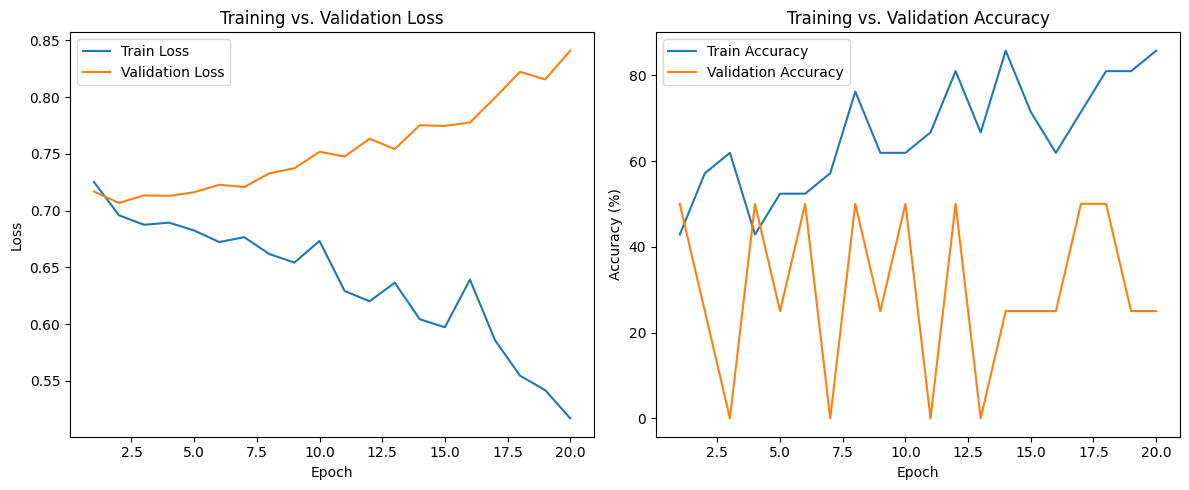

In [49]:
# Plot training & validation loss and accuracy
epochs = range(1, num_epochs+1)
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Loss curve
axes[0].plot(epochs, train_losses, label='Train Loss')
axes[0].plot(epochs, val_losses, label='Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training vs. Validation Loss')
axes[0].legend()

# Accuracy curve
axes[1].plot(epochs, [acc*100 for acc in train_accs], label='Train Accuracy')
axes[1].plot(epochs, [acc*100 for acc in val_accs], label='Validation Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training vs. Validation Accuracy')
axes[1].legend()

plt.tight_layout()
plt.show()


Test Accuracy: 66.67%
Test Classification Report:
              precision    recall  f1-score   support

     Class 0       0.60      1.00      0.75         3
     Class 1       1.00      0.33      0.50         3

    accuracy                           0.67         6
   macro avg       0.80      0.67      0.62         6
weighted avg       0.80      0.67      0.62         6



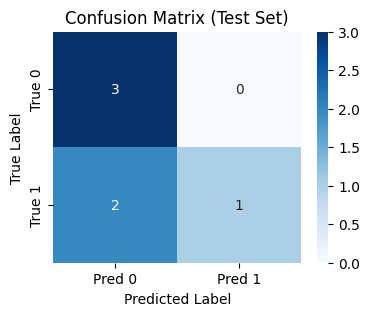

In [50]:
# Evaluate on test set
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, preds = torch.max(outputs, dim=1)
        # Since test_loader has batch_size=1, we get one prediction at a time
        y_true.append(int(y_batch.item()))
        y_pred.append(int(preds.item()))

# Calculate accuracy
test_accuracy = accuracy_score(y_true, y_pred)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))
print("Test Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Class 0", "Class 1"]))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=["Pred 0","Pred 1"], yticklabels=["True 0","True 1"])
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


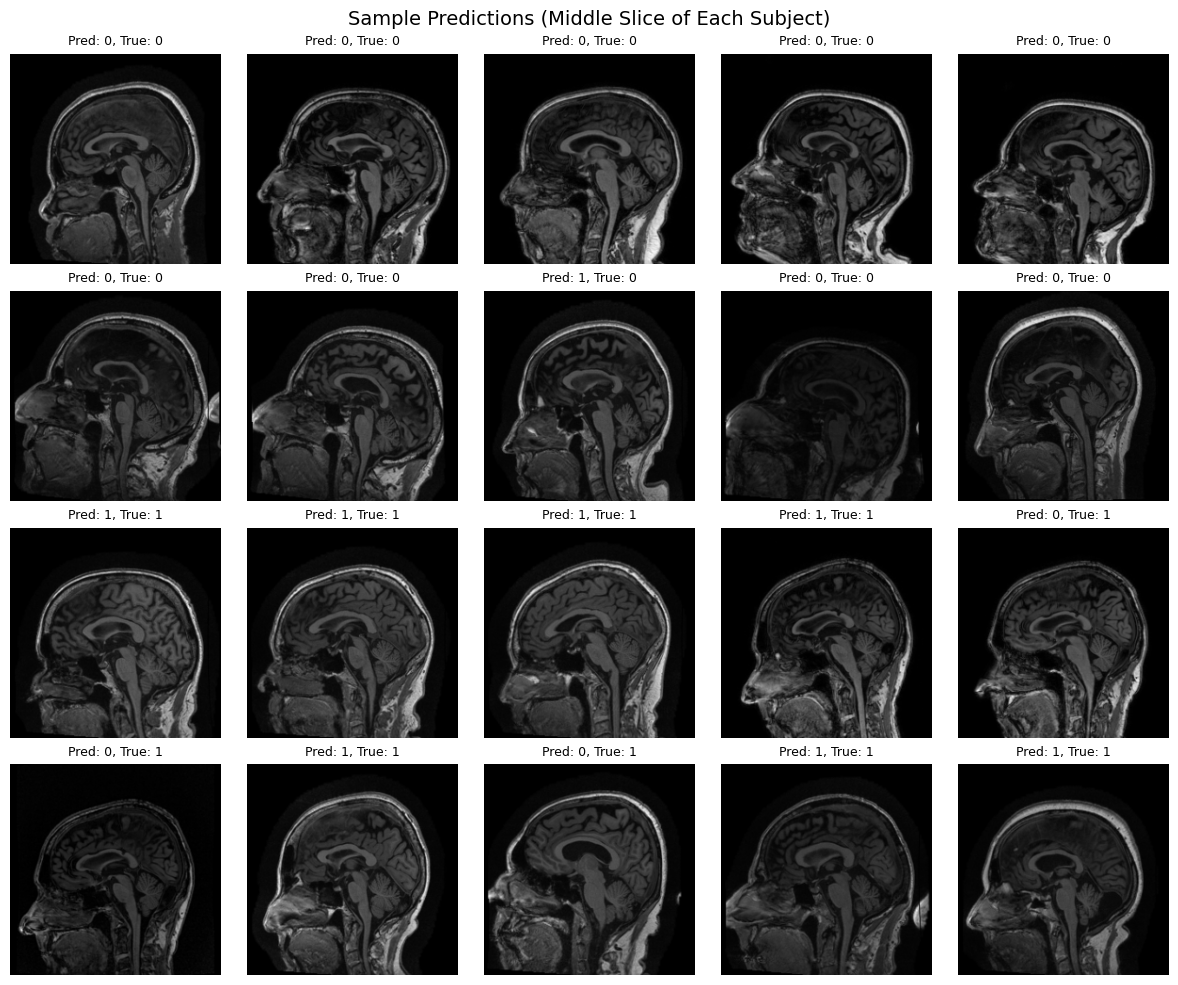

In [51]:
# Select 20 subjects to visualize (if fewer in dataset, adjust accordingly)
num_visualize = 20
# We will pick 10 from class 0 and 10 from class 1 for diversity, if possible
indices_to_show = []
indices_to_show += [i for i in range(len(all_labels)) if all_labels[i] == 0][:10]
indices_to_show += [i for i in range(len(all_labels)) if all_labels[i] == 1][:10]
indices_to_show = indices_to_show[:num_visualize]  # ensure we have exactly 20 (or less if not enough data)

fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(12, 10))
axes = axes.flatten()
for ax, idx in zip(axes, indices_to_show):
    # Get the sequence and true label
    seq_tensor = X[idx]                # shape [32, 3, 224, 224]
    true_label = all_labels[idx]
    # Run the model on this sequence (1 subject)
    seq_tensor = seq_tensor.unsqueeze(0).to(device)  # add batch dimension -> [1,32,3,224,224]
    model.eval()
    with torch.no_grad():
        output = model(seq_tensor)
        _, pred_label = torch.max(output, dim=1)
        pred_label = int(pred_label.item())
    # Get the middle slice (index 15 or 16)
    mid_slice_idx = 15
    # Unnormalize the image for display
    mid_slice = X[idx, mid_slice_idx]  # shape [3,224,224], still normalized
    mid_slice = mid_slice * 0.5 + 0.5  # revert normalization (now ~0-1 range)
    # Convert to numpy for plotting
    img_np = mid_slice.cpu().numpy()
    # Take one channel (all channels are identical after unnorm)
    img_gray = img_np[0]  # shape [224,224]
    # Plot the slice
    ax.imshow(img_gray, cmap='gray', vmin=0, vmax=1)
    ax.axis('off')
    ax.set_title(f"Pred: {pred_label}, True: {true_label}", fontsize=9)
# Remove any empty subplots if fewer than 20
for j in range(len(indices_to_show), len(axes)):
    axes[j].axis('off')
plt.suptitle("Sample Predictions (Middle Slice of Each Subject)", fontsize=14)
plt.tight_layout()
plt.show()


In [71]:
import os, glob
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from datasets import load_dataset

# Load the HuggingFace Alzheimer MRI dataset (train and test splits)
dataset_train = load_dataset('Falah/Alzheimer_MRI', split='train')
dataset_test  = load_dataset('Falah/Alzheimer_MRI', split='test')  # we'll use this as our validation set for early stopping

# Get class names from the dataset's features
class_names = dataset_train.features['label'].names  # e.g., ["Mild_Demented", "Moderate_Demented", "Non_Demented", "Very_Mild_Demented"]
num_classes = len(class_names)

# Define image transformations
# Convert images to RGB (in case they're grayscale), resize to 224x224, apply augmentation for training, and normalize.
train_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),          # ensure 3-channel RGB
    transforms.Resize((224, 224)),                              # resize to 224x224
    transforms.RandomHorizontalFlip(),                          # random horizontal flip for augmentation
    transforms.RandomRotation(10),                              # random rotation up to 10 degrees for augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # normalize pixel values to [-1, 1]
])
# Validation/test transforms (no augmentation, just resize and normalize)
val_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create a PyTorch Dataset wrapper for the HuggingFace dataset to apply transforms
class HFDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.hf_dataset = hf_dataset
        self.transform = transform
    def __len__(self):
        return len(self.hf_dataset)
    def __getitem__(self, idx):
        sample = self.hf_dataset[idx]
        img = sample['image']
        label = sample['label']
        # Convert to PIL Image if not already
        if not isinstance(img, Image.Image):
            img = Image.fromarray(np.array(img))
        # Apply transform if provided
        if self.transform:
            img = self.transform(img)
        return img, label

# Wrap the loaded datasets with the custom Dataset and transformations
train_dataset = HFDataset(dataset_train, transform=train_transform)
val_dataset   = HFDataset(dataset_test, transform=val_transform)   # using test split as validation for early stopping

# Create DataLoaders for training and validation
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [72]:
import torch.nn as nn
from transformers import ViTModel

class ViTBiLSTM(nn.Module):
    def __init__(self, num_classes):
        super(ViTBiLSTM, self).__init__()
        # Load a pre-trained ViT model (base size, 16x16 patches, pre-trained on ImageNet21k)
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        # BiLSTM to process the sequence of patch embeddings from ViT
        self.lstm = nn.LSTM(input_size=self.vit.config.hidden_size,  # hidden size of ViT embeddings (e.g., 768)
                             hidden_size=128,    # LSTM hidden state size (128 in each direction)
                             num_layers=1,
                             batch_first=True,
                             bidirectional=True)
        # Fully connected layer for classification (input 256 because 128*2 from BiLSTM, output = num_classes)
        self.fc = nn.Linear(128 * 2, num_classes)

    def forward(self, x):
        # ViT model expects pixel_values of shape (batch, 3, H, W) normalized as done above
        vit_outputs = self.vit(pixel_values=x)
        # Get sequence of patch embeddings from the last hidden state (including [CLS] token at index 0)
        seq_embeddings = vit_outputs.last_hidden_state  # shape: (batch, sequence_length, hidden_size)
        # Exclude the [CLS] token embedding for LSTM input (take patch embeddings only)
        patch_embeddings = seq_embeddings[:, 1:, :]     # shape: (batch, num_patches, hidden_size)
        # Pass patch embeddings through BiLSTM
        # lstm_out shape: (batch, num_patches, hidden_size*2) for bidirectional LSTM
        # h_n shape: (num_directions, batch, hidden_size)
        _, (h_n, _) = self.lstm(patch_embeddings)
        # Concatenate the final forward and backward hidden states
        h_forward = h_n[0]        # final hidden state of forward direction
        h_backward = h_n[1]       # final hidden state of backward direction
        h_concat = torch.cat((h_forward, h_backward), dim=1)  # shape: (batch, 128*2)
        # Final classification layer
        logits = self.fc(h_concat)  # shape: (batch, num_classes)
        return logits

# Instantiate the model and move it to the available device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViTBiLSTM(num_classes=num_classes).to(device)


In [73]:
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # using a relatively low LR for fine-tuning

# Early stopping parameters
num_epochs = 20
patience = 3
best_val_loss = float('inf')
patience_counter = 0

# Training loop
for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    # Compute average training loss for the epoch
    train_loss = running_loss / len(train_loader.dataset)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            # Calculate accuracy
            _, preds = torch.max(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = correct / total

    # Print epoch results
    print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_accuracy:.4f}")

    # Check for improvement for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model weights
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Training complete. Load the best model weights before evaluation.
model.load_state_dict(torch.load("best_model.pth"))
model.to(device)
model.eval()


Epoch 1: Train Loss = 0.8915, Val Loss = 0.8288, Val Acc = 0.6055
Epoch 2: Train Loss = 0.7318, Val Loss = 0.6604, Val Acc = 0.7211
Epoch 3: Train Loss = 0.6000, Val Loss = 0.5755, Val Acc = 0.7586
Epoch 4: Train Loss = 0.4393, Val Loss = 0.5441, Val Acc = 0.7664
Epoch 5: Train Loss = 0.3595, Val Loss = 0.3206, Val Acc = 0.8812
Epoch 6: Train Loss = 0.2131, Val Loss = 0.2150, Val Acc = 0.9187
Epoch 7: Train Loss = 0.1591, Val Loss = 0.1682, Val Acc = 0.9437
Epoch 8: Train Loss = 0.1148, Val Loss = 0.2608, Val Acc = 0.9141
Epoch 9: Train Loss = 0.1042, Val Loss = 0.1761, Val Acc = 0.9414
Epoch 10: Train Loss = 0.0637, Val Loss = 0.1239, Val Acc = 0.9570
Epoch 11: Train Loss = 0.0986, Val Loss = 0.2286, Val Acc = 0.9203
Epoch 12: Train Loss = 0.0498, Val Loss = 0.1286, Val Acc = 0.9625
Epoch 13: Train Loss = 0.0721, Val Loss = 0.1042, Val Acc = 0.9594
Epoch 14: Train Loss = 0.0488, Val Loss = 0.1428, Val Acc = 0.9523
Epoch 15: Train Loss = 0.0560, Val Loss = 0.0835, Val Acc = 0.9727
Epoc

ViTBiLSTM(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermediate_act_fn): GE

✅ Model loaded.
Found 31 NIfTI files.


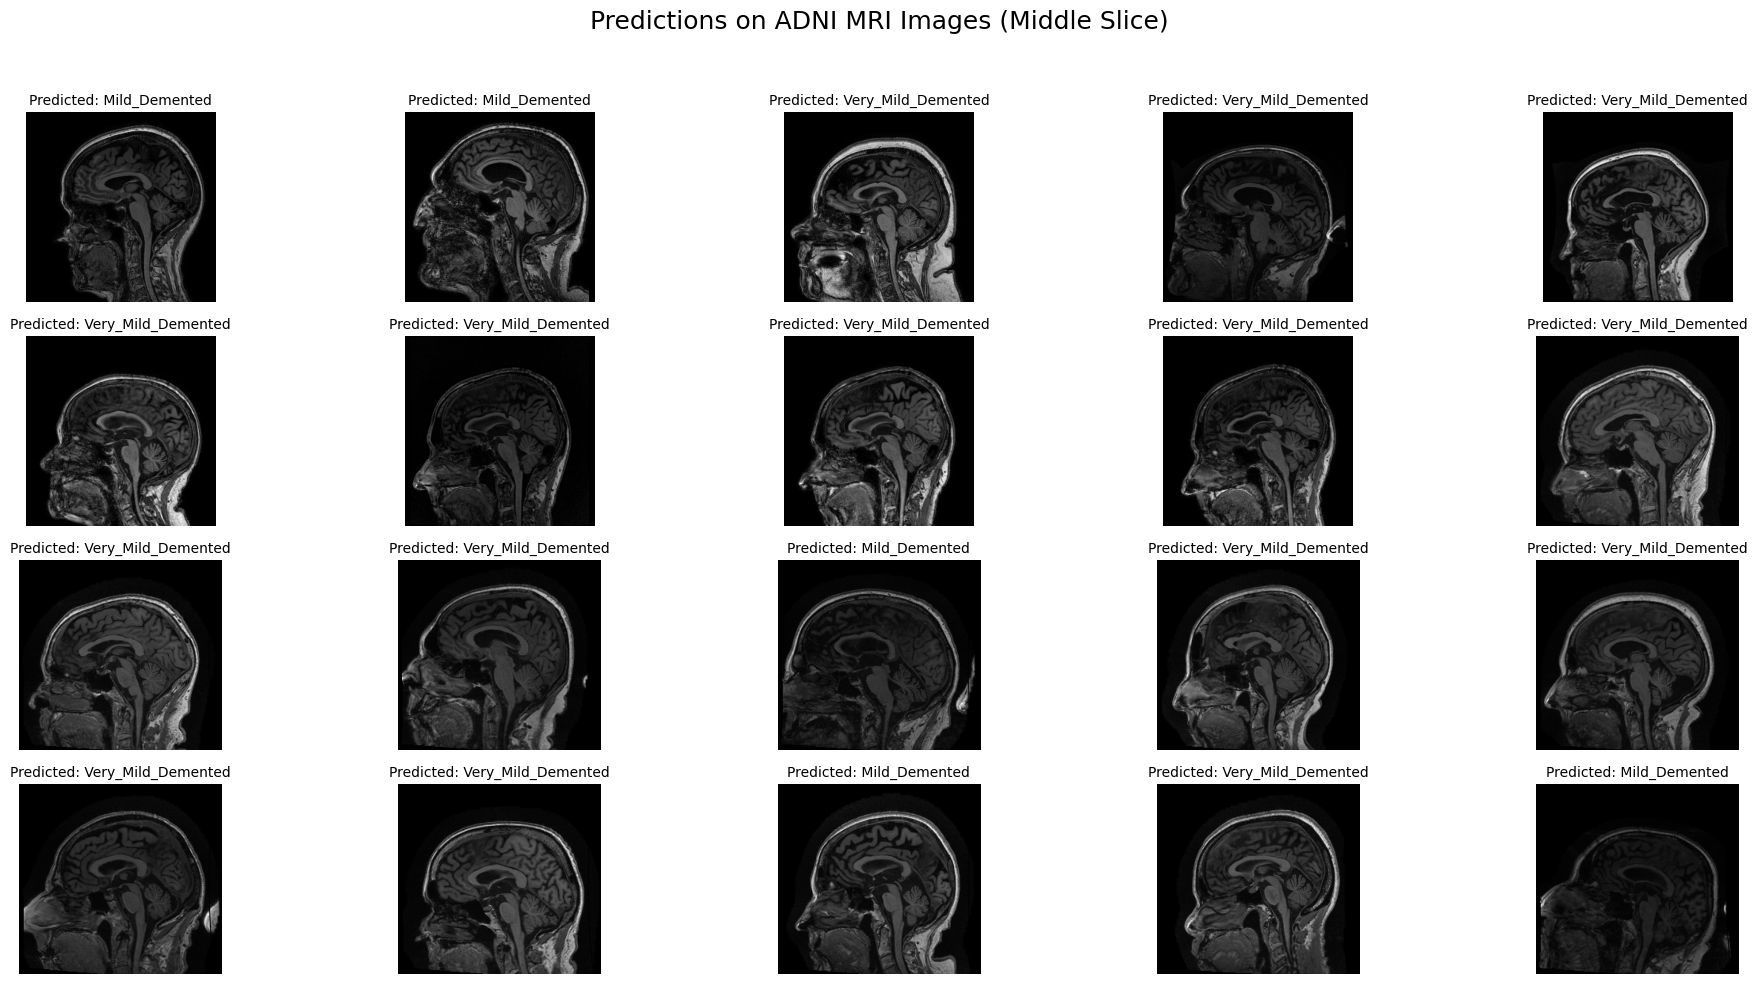

In [76]:
import os
import glob
import torch
import torch.nn as nn
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from transformers import ViTModel

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define class names
class_names = ["Mild_Demented", "Moderate_Demented", "Non_Demented", "Very_Mild_Demented"]

# Define validation transforms
val_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Define the model architecture (MUST match training)
class ViTBiLSTM(nn.Module):
    def __init__(self, num_classes=4):
        super(ViTBiLSTM, self).__init__()
        self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.lstm = nn.LSTM(input_size=768, hidden_size=128, num_layers=1,
                            batch_first=True, bidirectional=True)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        vit_outputs = self.vit(pixel_values=x)
        patch_embeddings = vit_outputs.last_hidden_state[:, 1:, :]  # exclude class token
        _, (h_n, _) = self.lstm(patch_embeddings)
        h_final = torch.cat((h_n[0], h_n[1]), dim=1)
        return self.fc(h_final)

# Load trained model
model = ViTBiLSTM(num_classes=4).to(device)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()
print("✅ Model loaded.")

# ADNI directory
adni_dir = "/content/drive/MyDrive/ADNI"

# Recursively find all .nii files
nii_paths = sorted(glob.glob(os.path.join(adni_dir, '**/*.nii'), recursive=True))
print(f"Found {len(nii_paths)} NIfTI files.")

# Limit to 20 for visualization
sample_paths = nii_paths[:20]

# Plot results
plt.figure(figsize=(20, 10))

for i, nii_path in enumerate(sample_paths):
    # Load and extract middle slice from 3D MRI
    nii_img = nib.load(nii_path)
    volume = nii_img.get_fdata()

    middle_slice = volume[:, :, volume.shape[2] // 2]
    normalized = 255 * (middle_slice - middle_slice.min()) / (np.ptp(middle_slice) + 1e-6)
    normalized = np.uint8(normalized)

    # Convert to RGB PIL image
    pil_img = Image.fromarray(normalized).convert("RGB")

    # Apply validation transform
    input_tensor = val_transform(pil_img).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        pred = torch.argmax(output, dim=1).item()

    # Plot
    plt.subplot(4, 5, i + 1)
    plt.imshow(pil_img)
    plt.title(f"Predicted: {class_names[pred]}", fontsize=10)
    plt.axis("off")

plt.suptitle("Predictions on ADNI MRI Images (Middle Slice)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


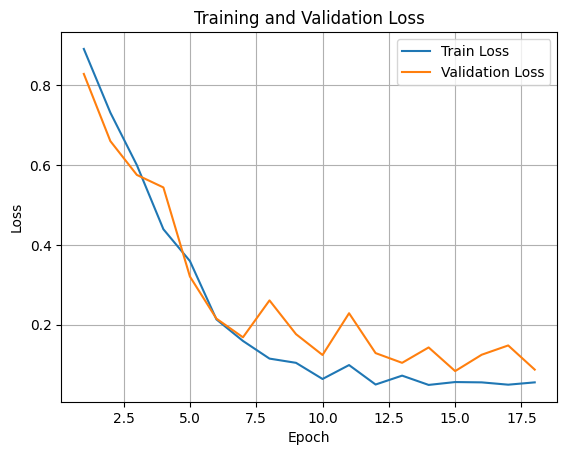

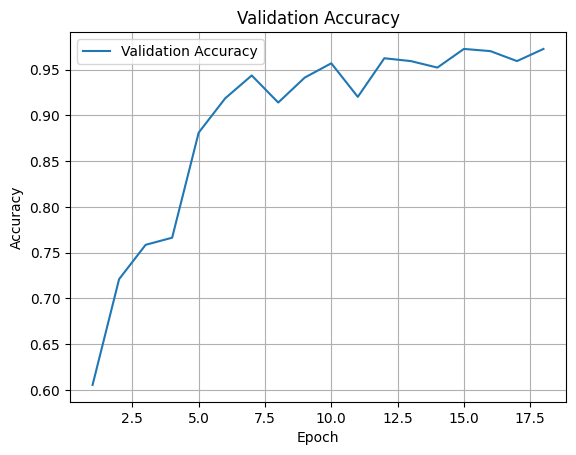

In [81]:
import matplotlib.pyplot as plt

# Manually input values based on training logs
train_loss = [0.8915, 0.7318, 0.6000, 0.4393, 0.3595, 0.2131, 0.1591, 0.1148, 0.1042, 0.0637, 0.0986, 0.0498, 0.0721, 0.0488, 0.0560, 0.0552, 0.0494, 0.0552]
val_loss   = [0.8288, 0.6604, 0.5755, 0.5441, 0.3206, 0.2150, 0.1682, 0.2608, 0.1761, 0.1239, 0.2286, 0.1286, 0.1042, 0.1428, 0.0835, 0.1245, 0.1478, 0.0872]

val_acc = [0.6055, 0.7211, 0.7586, 0.7664, 0.8812, 0.9187, 0.9437, 0.9141, 0.9414, 0.9570, 0.9203, 0.9625, 0.9594, 0.9523, 0.9727, 0.9703, 0.9594, 0.9727]

epochs = list(range(1, len(train_loss)+1))

# Plot loss
plt.figure()
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
plt.figure()
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()
